# CS634 Final Project – Diabetes Prediction Using RF, LSTM, and SVM  
**Sonani_Rutvik**  
NJIT | Dr. Yasser Abduallah | November 2025  

---

## Project Goal  
This project applies **three binary classification models** to the ** Diabetes Dataset** to predict whether a patient has diabetes (`Outcome = 1`) or not (`Outcome = 0`).  

**Algorithms Used:**  
1. **Random Forest** – Ensemble method (mandatory)  
2. **LSTM** – Deep learning model  
3. **SVM** – Traditional ML classifier  

**Validation:** 10-fold **stratified** cross-validation  
**Metrics:** Computed **manually** (except confusion matrix)  
**ROC, AUC, BS, BSS:** Used `sklearn`

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, brier_score_loss

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

## Loading and Preprocessing Data

In [43]:
diabetes_data = pd.read_csv('diabetes.csv')

print("Dataset loaded. Shape:", diabetes_data.shape)
print("\nFirst 5 rows:")
print(diabetes_data.head())

print("\nDataset Info:")
print(diabetes_data.info())

Dataset loaded. Shape: (768, 9)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies           

## Data Exploration
Check for imbalance and correlations.

In [44]:
# Load the diabetes dataset
diabetes_data = pd.read_csv('diabetes.csv')

# Display basic info and first few rows
print("Dataset loaded. Shape:", diabetes_data.shape)
print("\nFirst 5 rows:")
print(diabetes_data.head())

print("\nDataset Info:")
print(diabetes_data.info())

Dataset loaded. Shape: (768, 9)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies           

## Handle Missing Values (Zeros → Median)

In [45]:
def replace_zeros_with_median(df):
    columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for col in columns_to_impute:
        median_val = df[col][df[col] != 0].median()
        df[col] = df[col].replace(0, median_val)
    return df

diabetes_data = replace_zeros_with_median(diabetes_data)

print("Zeros replaced with median values.")
print(diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].describe())

Zeros replaced with median values.
          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   121.656250      72.386719      29.108073  140.671875   32.455208
std     30.438286      12.096642       8.791221   86.383060    6.875177
min     44.000000      24.000000       7.000000   14.000000   18.200000
25%     99.750000      64.000000      25.000000  121.500000   27.500000
50%    117.000000      72.000000      29.000000  125.000000   32.300000
75%    140.250000      80.000000      32.000000  127.250000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000


## Visualize Class Distribution

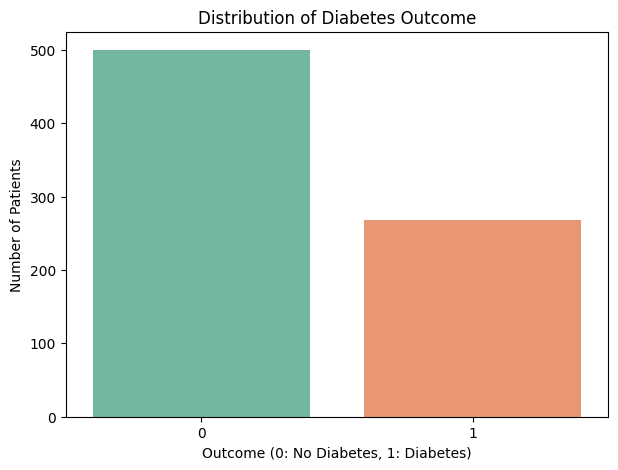

Number of patients with diabetes: 268 (34.9%)
Number of patients without diabetes: 500 (65.1%)


In [46]:
plt.figure(figsize=(7, 5))
sns.countplot(x='Outcome', data=diabetes_data, palette='Set2')
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Outcome (0: No Diabetes, 1: Diabetes)')
plt.ylabel('Number of Patients')
plt.show()

positive_cases = diabetes_data['Outcome'].value_counts()[1]
negative_cases = diabetes_data['Outcome'].value_counts()[0]
total_patients = len(diabetes_data)

print(f"Number of patients with diabetes: {positive_cases} ({positive_cases/total_patients*100:.1f}%)")
print(f"Number of patients without diabetes: {negative_cases} ({negative_cases/total_patients*100:.1f}%)")

## Correlation Heatmap

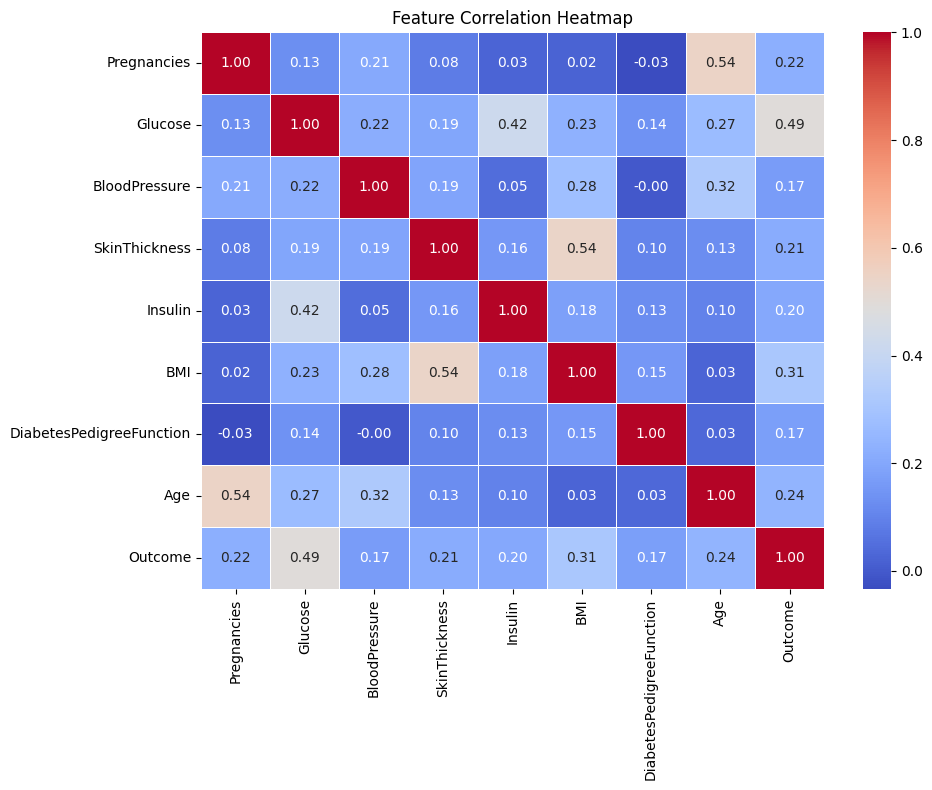

Notable correlations:
- Age and Pregnancies: 0.54
- BMI and SkinThickness: 0.54


In [47]:
plt.figure(figsize=(10, 8))
correlation_matrix = diabetes_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("Notable correlations:")
print("- Age and Pregnancies:", correlation_matrix.loc['Age', 'Pregnancies'].round(2))
print("- BMI and SkinThickness:", correlation_matrix.loc['BMI', 'SkinThickness'].round(2))

## Split Features and Target

In [48]:
input_features = diabetes_data.drop('Outcome', axis=1)
target_label = diabetes_data['Outcome']

print("Features shape:", input_features.shape)
print("Target shape:", target_label.shape)

Features shape: (768, 8)
Target shape: (768,)


## Custom Metrics Function

In [49]:
def evaluate_model_performance(y_actual, y_predicted, y_probability):
    tn, fp, fn, tp = confusion_matrix(y_actual, y_predicted).ravel()
    total_positive = tp + fn
    total_negative = tn + fp

    sensitivity = tp / total_positive if total_positive > 0 else 0
    specificity = tn / total_negative if total_negative > 0 else 0
    false_positive_rate = fp / total_negative if total_negative > 0 else 0
    false_negative_rate = fn / total_positive if total_positive > 0 else 0

    accuracy = (tp + tn) / (total_positive + total_negative)
    balanced_accuracy = (sensitivity + specificity) / 2
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = sensitivity
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    error_rate = 1 - accuracy

    true_skill_statistic = sensitivity - false_positive_rate
    heidke_skill_score = 2 * (tp * tn - fp * fn) / ((tp + fn)*(fn + tn) + (tp + fp)*(fp + tn)) \
                         if ((tp + fn)*(fn + tn) + (tp + fp)*(fp + tn)) > 0 else 0

    auc_score = roc_auc_score(y_actual, y_probability)
    fpr_curve, tpr_curve, _ = roc_curve(y_actual, y_probability)
    brier_loss = brier_score_loss(y_actual, y_probability)
    baseline_brier = target_label.mean() * (1 - target_label.mean())
    brier_skill_score = 1 - (brier_loss / baseline_brier) if baseline_brier > 0 else 0

    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Sensitivity': sensitivity, 'Specificity': specificity,
        'FPR': false_positive_rate, 'FNR': false_negative_rate,
        'Accuracy': accuracy, 'Balanced Accuracy': balanced_accuracy,
        'Precision': precision, 'Recall': recall, 'F1-Score': f1_score,
        'Error Rate': error_rate, 'TSS': true_skill_statistic, 'HSS': heidke_skill_score,
        'AUC': auc_score, 'Brier Loss': brier_loss, 'BSS': brier_skill_score,
        'fpr_curve': fpr_curve, 'tpr_curve': tpr_curve
    }

## Setup 10-Fold Stratified CV

In [50]:
# Initialize stratified k-fold
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
feature_scaler = StandardScaler()

print("10-fold stratified cross-validation ready.")

10-fold stratified cross-validation ready.


## Random Forest – Training & Evaluation

In [51]:
rf_results = []
rf_probabilities = []

print("Training Random Forest across 10 folds...\n")
for fold_num, (train_idx, test_idx) in enumerate(cv_strategy.split(input_features, target_label), 1):
    X_train_fold, X_test_fold = input_features.iloc[train_idx], input_features.iloc[test_idx]
    y_train_fold, y_test_fold = target_label.iloc[train_idx], target_label.iloc[test_idx]

    X_train_scaled = feature_scaler.fit_transform(X_train_fold)
    X_test_scaled = feature_scaler.transform(X_test_fold)

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.fit(X_train_scaled, y_train_fold)

    y_pred_rf = rf_classifier.predict(X_test_scaled)
    y_prob_rf = rf_classifier.predict_proba(X_test_scaled)[:, 1]

    fold_metrics = evaluate_model_performance(y_test_fold, y_pred_rf, y_prob_rf)
    rf_results.append(fold_metrics)
    rf_probabilities.append((y_test_fold.values, y_prob_rf))

    print(f"Fold {fold_num}: Accuracy = {fold_metrics['Accuracy']:.3f}, AUC = {fold_metrics['AUC']:.3f}")

rf_avg_metrics = {k: np.mean([m[k] for m in rf_results]) for k in rf_results[0] if k not in ['fpr_curve', 'tpr_curve']}

Training Random Forest across 10 folds...

Fold 1: Accuracy = 0.753, AUC = 0.853
Fold 2: Accuracy = 0.779, AUC = 0.828
Fold 3: Accuracy = 0.701, AUC = 0.746
Fold 4: Accuracy = 0.870, AUC = 0.915
Fold 5: Accuracy = 0.818, AUC = 0.858
Fold 6: Accuracy = 0.766, AUC = 0.833
Fold 7: Accuracy = 0.753, AUC = 0.822
Fold 8: Accuracy = 0.792, AUC = 0.840
Fold 9: Accuracy = 0.763, AUC = 0.826
Fold 10: Accuracy = 0.697, AUC = 0.753


## LSTM – Training & Evaluation

In [52]:
lstm_results = []
lstm_probabilities = []

print("\nTraining LSTM across 10 folds...\n")
for fold_num, (train_idx, test_idx) in enumerate(cv_strategy.split(input_features, target_label), 1):
    X_train_fold, X_test_fold = input_features.iloc[train_idx], input_features.iloc[test_idx]
    y_train_fold, y_test_fold = target_label.iloc[train_idx], target_label.iloc[test_idx]

    X_train_scaled = feature_scaler.fit_transform(X_train_fold)
    X_test_scaled = feature_scaler.transform(X_test_fold)

    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    lstm_model = Sequential([
        LSTM(50, input_shape=(1, X_train_scaled.shape[1])),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam')

    lstm_model.fit(X_train_lstm, y_train_fold, epochs=20, batch_size=32, verbose=0)

    y_prob_lstm = lstm_model.predict(X_test_lstm).flatten()
    y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

    fold_metrics = evaluate_model_performance(y_test_fold, y_pred_lstm, y_prob_lstm)
    lstm_results.append(fold_metrics)
    lstm_probabilities.append((y_test_fold.values, y_prob_lstm))

    print(f"Fold {fold_num}: Accuracy = {fold_metrics['Accuracy']:.3f}, AUC = {fold_metrics['AUC']:.3f}")

lstm_avg_metrics = {k: np.mean([m[k] for m in lstm_results]) for k in lstm_results[0] if k not in ['fpr_curve', 'tpr_curve']}


Training LSTM across 10 folds...

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Fold 1: Accuracy = 0.727, AUC = 0.847
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Fold 2: Accuracy = 0.779, AUC = 0.830
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Fold 3: Accuracy = 0.753, AUC = 0.796
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Fold 4: Accuracy = 0.844, AUC = 0.930
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Fold 5: Accuracy = 0.753, AUC = 0.830
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Fold 6: Accuracy = 0.792, AUC = 0.864
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Fold 7: Accuracy = 0.779, AUC = 0.835
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Fold 8: Accuracy = 0.740, AUC = 0.849
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Fold 9: Accuracy = 0.763, AUC = 0.868
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Fold 10: Accuracy = 0.711, AUC = 0.765


## SVM – Training & Evaluation

In [53]:
svm_results = []
svm_probabilities = []

print("\nTraining SVM across 10 folds...\n")
for fold_num, (train_idx, test_idx) in enumerate(cv_strategy.split(input_features, target_label), 1):
    X_train_fold, X_test_fold = input_features.iloc[train_idx], input_features.iloc[test_idx]
    y_train_fold, y_test_fold = target_label.iloc[train_idx], target_label.iloc[test_idx]

    X_train_scaled = feature_scaler.fit_transform(X_train_fold)
    X_test_scaled = feature_scaler.transform(X_test_fold)

    svm_classifier = SVC(probability=True, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train_fold)

    y_pred_svm = svm_classifier.predict(X_test_scaled)
    y_prob_svm = svm_classifier.predict_proba(X_test_scaled)[:, 1]

    fold_metrics = evaluate_model_performance(y_test_fold, y_pred_svm, y_prob_svm)
    svm_results.append(fold_metrics)
    svm_probabilities.append((y_test_fold.values, y_prob_svm))

    print(f"Fold {fold_num}: Accuracy = {fold_metrics['Accuracy']:.3f}, AUC = {fold_metrics['AUC']:.3f}")

svm_avg_metrics = {k: np.mean([m[k] for m in svm_results]) for k in svm_results[0] if k not in ['fpr_curve', 'tpr_curve']}


Training SVM across 10 folds...

Fold 1: Accuracy = 0.727, AUC = 0.827
Fold 2: Accuracy = 0.714, AUC = 0.835
Fold 3: Accuracy = 0.714, AUC = 0.780
Fold 4: Accuracy = 0.844, AUC = 0.913
Fold 5: Accuracy = 0.753, AUC = 0.807
Fold 6: Accuracy = 0.792, AUC = 0.844
Fold 7: Accuracy = 0.753, AUC = 0.813
Fold 8: Accuracy = 0.714, AUC = 0.830
Fold 9: Accuracy = 0.750, AUC = 0.842
Fold 10: Accuracy = 0.711, AUC = 0.762


## Per-fold metric tables

In [54]:
print("\n" + "="*80)
print("PER-FOLD DETAILED METRICS (10 FOLDS)")
print("="*80)

def print_fold_metrics(model_name, results_list):
    print(f"\n{model_name.upper()} PER-FOLD RESULTS")
    print("-" * 60)
    for fold in range(len(results_list)):
        m = results_list[fold]
        print(f"FOLD {fold + 1}")
        skip_keys = ['fpr_curve', 'tpr_curve']
        for k, v in m.items():
            if k not in skip_keys:
                print(f"  {k:20}: {v:.4f}")
        print()

print_fold_metrics("Random Forest", rf_results)   
print_fold_metrics("SVM", svm_results)
print_fold_metrics("LSTM", lstm_results)         


PER-FOLD DETAILED METRICS (10 FOLDS)

RANDOM FOREST PER-FOLD RESULTS
------------------------------------------------------------
FOLD 1
  TP                  : 19.0000
  TN                  : 39.0000
  FP                  : 11.0000
  FN                  : 8.0000
  Sensitivity         : 0.7037
  Specificity         : 0.7800
  FPR                 : 0.2200
  FNR                 : 0.2963
  Accuracy            : 0.7532
  Balanced Accuracy   : 0.7419
  Precision           : 0.6333
  Recall              : 0.7037
  F1-Score            : 0.6667
  Error Rate          : 0.2468
  TSS                 : 0.4837
  HSS                 : 0.4717
  AUC                 : 0.8530
  Brier Loss          : 0.1516
  BSS                 : 0.3329

FOLD 2
  TP                  : 16.0000
  TN                  : 44.0000
  FP                  : 6.0000
  FN                  : 11.0000
  Sensitivity         : 0.5926
  Specificity         : 0.8800
  FPR                 : 0.1200
  FNR                 : 0.4074
  Accuracy 

## Summary Table

In [55]:
summary_rows = []
metric_names = [k for k in rf_avg_metrics.keys() if k not in ['fpr_curve', 'tpr_curve']]

for metric in metric_names:
    summary_rows.append({
        'Metric': metric,
        'Random Forest': round(rf_avg_metrics[metric], 4),
        'LSTM': round(lstm_avg_metrics[metric], 4),
        'SVM': round(svm_avg_metrics[metric], 4)
    })

final_summary = pd.DataFrame(summary_rows)
print("\n" + "="*80)
print("AVERAGE PERFORMANCE ACROSS 10 FOLDS")
print("="*80)
print(final_summary.to_string(index=False))


AVERAGE PERFORMANCE ACROSS 10 FOLDS
           Metric  Random Forest    LSTM     SVM
               TP        16.5000 15.9000 14.4000
               TN        42.6000 42.8000 43.0000
               FP         7.4000  7.2000  7.0000
               FN        10.3000 10.9000 12.4000
      Sensitivity         0.6158  0.5933  0.5373
      Specificity         0.8520  0.8560  0.8600
              FPR         0.1480  0.1440  0.1400
              FNR         0.3842  0.4067  0.4627
         Accuracy         0.7694  0.7643  0.7474
Balanced Accuracy         0.7339  0.7247  0.6987
        Precision         0.6963  0.6996  0.6802
           Recall         0.6158  0.5933  0.5373
         F1-Score         0.6495  0.6350  0.5971
       Error Rate         0.2306  0.2357  0.2526
              TSS         0.4678  0.4493  0.3973
              HSS         0.4795  0.4639  0.4171
              AUC         0.8273  0.8415  0.8253
       Brier Loss         0.1606  0.1552  0.1636
              BSS         0.2929

## Plot Average ROC Curves

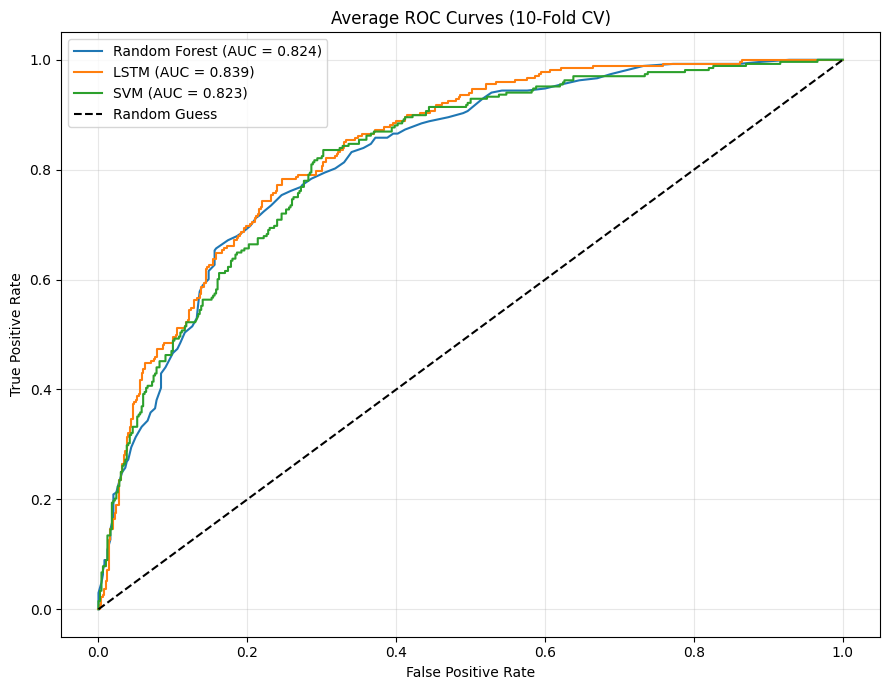

In [56]:
plt.figure(figsize=(9, 7))

def plot_roc_curve(prob_list, model_name):
    all_y = np.concatenate([y for y, _ in prob_list])
    all_prob = np.concatenate([p for _, p in prob_list])
    fpr, tpr, _ = roc_curve(all_y, all_prob)
    auc_val = roc_auc_score(all_y, all_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_val:.3f})')

plot_roc_curve(rf_probabilities, 'Random Forest')
plot_roc_curve(lstm_probabilities, 'LSTM')
plot_roc_curve(svm_probabilities, 'SVM')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curves (10-Fold CV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Saved Plots

In [57]:
plt.figure(figsize=(7,5))
sns.countplot(x='Outcome', data=diabetes_data, palette='Set2')
plt.title('Diabetes Outcome Distribution')
plt.savefig('outcome_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(9,7))

def plot_roc_curve(prob_list, model_name):
    all_y = np.concatenate([y for y, _ in prob_list])
    all_prob = np.concatenate([p for _, p in prob_list])
    fpr, tpr, _ = roc_curve(all_y, all_prob)
    auc_val = roc_auc_score(all_y, all_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_val:.3f})')

# plot each model's ROC (ensure these probability lists exist from your CV)
plot_roc_curve(rf_probabilities, 'Random Forest')
plot_roc_curve(lstm_probabilities, 'LSTM')
plot_roc_curve(svm_probabilities, 'SVM')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curves (10-Fold CV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

print("Plots saved: outcome_distribution.png, correlation_heatmap.png, roc_curves.png")


Plots saved: outcome_distribution.png, correlation_heatmap.png, roc_curves.png
